In [1]:
# Helper to adjust contrast of a given structure

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/MovieMitosis
Fri May 27 10:59:59 PDT 2022


In [3]:
import os
import sys
import pickle
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
device = io.LocalStagingIO(control)
df = device.load_step_manifest("loaddata")
print(df.shape)

(216062, 46)


### Load single cell data

In [194]:
#8DSphere,I1,I1,I2,I2,M1,M1,M2,M2
selection ={
    "FBL": [740512,701726,692380,733192,737116,595838,679796],
    "NPM1": [718517,695492,665257,648039,728576,715832,718204], 
    "SON": [445840,458699,430100,440390,526746,488155,526387], 
    "SMC1A": [991914,995492,1000952,997242,1003701,995510,991109], 
    "HIST1H2BJ": [640568,595047,628321,643065,604000,720237,723824], 
    "LMNB1": [305545,294206,305698,306717,311189,291693,290906], 
    "NUP153": [877931,869334,791859,825282,870834,797779,818877], 
    "SEC61B": [371380,956851,391401,964210,387192,374984,383224], 
    "ATP2A2": [897787,902487,776630,923350,913067,792312,846933], 
    "TOMM20": [345450,323649,231741,275637,326116,322489,342166], 
    "SLC25A17": [769937,838436,769181,832085,801462,825160,803987], 
    "RAB5A": [842978,767213,827685,743220,934452,819639,933793], 
    "LAMP1": [630923,659611,635519,657573,640581,632595,628172], 
    "ST6GAL1": [475558,419883,450088,418730,465170,817818,418815], 
    "CETN2": [940167,939637,452230,934838,413192,426417,940506], 
    "TUBA1B": [905733,251726,895276,251426,262897,233419,250450], 
    "AAVS1": [502880,480748,502388,933669,617207,629413,612339], 
    "ACTB": [767053,416708,430466,470998,435839,437629,472817], 
    "ACTN1": [580932,973479,555039,527830,554833,525204,531803], 
    "MYH10": [512365,563521,554120,527685,482558,508915,582629], 
    "GJA1": [970064,513425,973391,508797,607690,486153,464229], 
    "TJP1": [516457,556162,545654,489565,541622,555913,544240], 
    "DSP": [370871,406746,370803,384905,403658,361366,368112], 
    "CTNNB1": [760396,747804,781356,758873,944928,945498,855928],
    "PXN": [589207,960441,957061,583806,959016,592189,975228]
}

genes = ["PXN"]
ncells = len(selection[genes[0]])

In [195]:
data = {}
chs = [3, 4, 2, 7]
for gene in genes:
    idimgs = []
    CellIds = selection[gene]
    for ncell, CellId in enumerate(CellIds):
        row = df.loc[CellId]
        row = common.redirect_single_cell_path(row)
        producer = io.DataProducer(control)
        producer.set_row(row)
        producer.load_single_cell_data()
#         producer.align_data()
        img = producer.data[chs]
        idimgs.append((CellId, img))
    data[gene] = [{"CellId": i, "img": img} for i, img in idimgs]

In [196]:
vmin, vmax = common.Projector.get_shared_gfp_range([img["img"][[0,1,3]] for img in data[genes[0]]], [20, 99.5])
print(genes[0], vmin, vmax)

PXN 0.0 0.0


In [197]:
(yyi, yyf, yzi, yzf), bbox, figargs = common.contact_sheet_params(box_size=300, ylow=110, zlow=70)

410 490
410 490
410 490
410 490
410 490
410 490
410 490


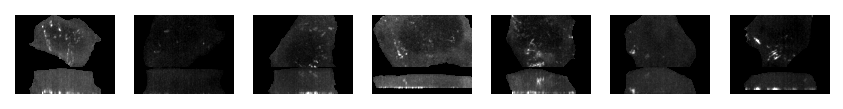

0 6
0 6
0 6
0 6
0 6
0 6
0 6


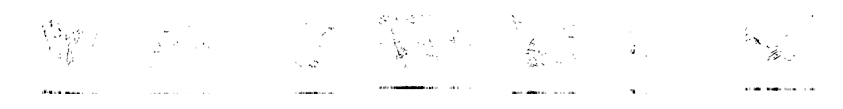

In [199]:
for ch, chname in enumerate(["raw", "seg"]):
    for gene in genes:
        fig, axs = plt.subplots(1, ncells, figsize=(ncells, 1), **figargs, dpi=150)
        for ncell, ax in enumerate(axs):
            ax.axis("off")
            instance = data[gene][ncell]["img"][[0, 1, 2+ch]]
            proj = common.Projector(instance, mask_on=True, force_fit=True)
            if ch: #seg data
                mode = {"nuc":"max","mem":"max","gfp":"mean"}
#                 v1 = 20 if gene not in seg_contrast else seg_contrast[gene]["vmin"]
#                 v2 = 99.9 if gene not in seg_contrast else seg_contrast[gene]["vmax"]
#                 proj.set_gfp_percentiles((v1, v2), local=True)
                v1, v2 = control.get_optimal_seg_contrast(gene)
                proj.set_vmin_vmax_gfp_values(v1, v2) ##################<<<<<<<<<<<<<<<
            else: #raw data
                mode = {"nuc":"max","mem":"max","gfp":"max"}
                v1, v2 = control.get_optimal_raw_contrast(gene)
                proj.set_vmin_vmax_gfp_values(v1, v2)
            proj.set_projection_mode(ax="z", mode=mode)
            proj.compute()
            print(proj.gfp_vmin, proj.gfp_vmax)
            pz = proj.projs["gfp"].copy()
            proj.set_projection_mode(ax="y", mode=mode)
            proj.compute()
            py = proj.projs["gfp"].copy()
            im = np.concatenate([py[yyi:yyf, :], pz[yzi:yzf, :]], axis=0)
            cmap = "binary" if ch else "gray"
            ax.imshow(im, cmap=cmap, origin="lower", vmin=proj.gfp_vmin, vmax=proj.gfp_vmax)
#         plt.savefig(f"FigureMorphingOverflow2_gfp_{chname}_{ncell}", dpi=150)
        plt.show()